# Final Project David Sant Starting to Normalize RNA and hMeDIP Data

## Introduction to what I am doing here

To start with, I have my raw count files. I have combined them already (using bash scripting), so it is in table format where it is tab delimited like this:

    Gene_ID | Sample 1 | Sample 2 | Sample 3 | Sample 4
    ENSRN0001 | 6 | 8 | 24| 29
    ENSRN0002 | 12 | 13 | 14 | 13
    ENSRN0003 | 18 | 17 | 1 | 0

For the RNA I also have results from edgeR and DESeq2. I have the transcript info from the GTF file in a csv file that I will use to determine transcript length.

For the hMeDIP samples I also have the edgeR statistical analysis, the bed file stating the location of the each peak (chromosome, start, stop, name of peak), the count data for genomic input (which was used for the peak calling and will be used for determining the cutoff of expression) and the region_analysis output which tells which gene the peak is close to. 

RNA-seq samples were aligned using STAR and then quantified using htseq-count. Both edgeR and DESeq2 are used for differential analysis and genes below a false discovery rate (FDR, also called adjusted P-value) of 0.05 by both DESeq2 and edgeR will be called differential. A limit of detection will be calculated using the genomic input from the hMeDIP-seq portion of the experiment. 

hMeDIP-seq peaks were called using the irreproducible discovery rate pipeline designed for the ChIP-seq portion of the ENCODE consortium. Counts were generated using htseq-count. Differential analysis was calculated using edgeR. To account for not having a second statistical program (DESeq2 can't normalize to all data), a cutoff of 1.5-fold change will be used in conjunction with an FDR of 0.05 by edgeR to determine differential peaks.

Genes that have more count data after treatment (increase in expression) or peaks that have higher count data (increase in enrichment from the antibody) are considered "Upregulated". 

More will be added here later. 


### Reading in the count files and normalizing them
The first step is going to be reading in the count files and normalizing them to total read counts. There will be multiple steps of normalization, but this is the first one.


In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
os.listdir("Input_Data/ARPE-19_Dataset")

['ARPE19.hMeDIP.counts.txt',
 'ARPE19_RNA.counts.txt',
 'ARPE19_Region.Analysis.txt',
 'ARPE19.hMeDIP.Control.vs.VitC.edgeR.csv',
 'ARPE19.Genomic.Input.counts.txt',
 'ARPE19_RNA.edgeR.csv',
 'ARPE19_RNA.DESeq2.csv',
 'ARPE19.hMeDIP.final_peaks.bed.txt']

In [3]:
os.listdir("Input_Data/")

['.DS_Store', 'HG38.90.Consensus.transcript.info.csv', 'ARPE-19_Dataset']

In [4]:
os.getcwd()

'/Users/david/Documents/David_Sant/Classes/Data_Science_COMP_5360/2019-datascience-homeworks/Final Project/Working from Raw Count Data'

In [5]:
Input_path = r"Input_Data/ARPE-19_Dataset/"
Output_Path = "Output_Tables_and_Results/"

Input_hMeDIP_Counts_File = Input_path+"ARPE19.hMeDIP.counts.txt"
Input_hMeDIP_edgeR = Input_path+"ARPE19.hMeDIP.Control.vs.VitC.edgeR.csv"
Input_region_analysis = Input_path+"ARPE19_Region.Analysis.txt"
Input_Genomic_Input_Counts_File = Input_path+"ARPE19.Genomic.Input.counts.txt"
Input_bed_file = Input_path+"ARPE19.hMeDIP.final_peaks.bed.txt"

Input_RNA_Counts_File = Input_path+"ARPE19_RNA.counts.txt"
Input_RNA_edgeR = Input_path+"ARPE19_RNA.edgeR.csv"
Input_RNA_DESeq2 = Input_path+"ARPE19_RNA.DESeq2.csv"

Input_genomic_info_file = "Input_Data/HG38.90.Consensus.transcript.info.csv"

In [6]:
ARPE_hMeDIP_raw = pd.read_csv(Input_hMeDIP_Counts_File, sep = "\t", index_col = 0)

In [7]:
print(len(ARPE_hMeDIP_raw))
ARPE_hMeDIP_raw.head()

150904


,ARPE19_Control_1_IP,ARPE19_Control_2_IP,ARPE19_LAA_1_IP,ARPE19_LAA_2_IP
Peak_Name,,,,
ARPE19.Control.peak_10,164,164,105,69
ARPE19.Control.peak_100033,76,93,55,38
ARPE19.Control.peak_10005,179,167,99,31
ARPE19.Control.peak_100056,80,105,66,57
ARPE19.Control.peak_10006,108,112,68,31


In [8]:
# Dave notes, axis = 0 means column wise; axis = 1 means row wise
# so a sum of axis=0 means the counts for the entire column
total_counts_ARPE_hMeDIP_Raw = ARPE_hMeDIP_raw.sum(axis=0)

In [9]:
total_counts_ARPE_hMeDIP_Raw[0]

72273855

In [10]:
ARPE_hMeDIP_raw["ARPE19_Control_1_IP_First_RCPM"] = ARPE_hMeDIP_raw["ARPE19_Control_1_IP"]*1000000/total_counts_ARPE_hMeDIP_Raw[0]
ARPE_hMeDIP_raw["ARPE19_Control_2_IP_First_RCPM"] = ARPE_hMeDIP_raw["ARPE19_Control_2_IP"]*1000000/total_counts_ARPE_hMeDIP_Raw[1]
ARPE_hMeDIP_raw["ARPE19_LAA_1_IP_First_RCPM"] = ARPE_hMeDIP_raw["ARPE19_LAA_1_IP"]*1000000/total_counts_ARPE_hMeDIP_Raw[2]
ARPE_hMeDIP_raw["ARPE19_LAA_2_IP_First_RCPM"] = ARPE_hMeDIP_raw["ARPE19_LAA_2_IP"]*1000000/total_counts_ARPE_hMeDIP_Raw[3]


In [11]:
ARPE_hMeDIP_raw["Control_Average"] = ARPE_hMeDIP_raw[["ARPE19_Control_1_IP_First_RCPM","ARPE19_Control_2_IP_First_RCPM" ]].mean(axis=1)
ARPE_hMeDIP_raw["VitC_Average"] = ARPE_hMeDIP_raw[["ARPE19_LAA_1_IP_First_RCPM","ARPE19_LAA_2_IP_First_RCPM" ]].mean(axis=1)


In [12]:
ARPE_hMeDIP_raw.head()


,ARPE19_Control_1_IP,ARPE19_Control_2_IP,ARPE19_LAA_1_IP,ARPE19_LAA_2_IP,ARPE19_Control_1_IP_First_RCPM,ARPE19_Control_2_IP_First_RCPM,ARPE19_LAA_1_IP_First_RCPM,ARPE19_LAA_2_IP_First_RCPM,Control_Average,VitC_Average
Peak_Name,,,,,,,,,,
ARPE19.Control.peak_10,164,164,105,69,2.269147,2.095616,1.790940,1.023705,2.182382,1.407323
ARPE19.Control.peak_100033,76,93,55,38,1.051556,1.188368,0.938111,0.563780,1.119962,0.750946
ARPE19.Control.peak_10005,179,167,99,31,2.476691,2.133951,1.688600,0.459926,2.305321,1.074263
ARPE19.Control.peak_100056,80,105,66,57,1.106901,1.341706,1.125734,0.845670,1.224303,0.985702
ARPE19.Control.peak_10006,108,112,68,31,1.494316,1.431153,1.159847,0.459926,1.462734,0.809886


In [13]:
# Dave Notes
# The sum of the FPKM columns is always going to be 1,000,000 (when I include all rows) because that is how I normalized it
# 1M/150904 gives the 6.626730 average

ARPE_hMeDIP_raw[["Control_Average","VitC_Average" ]].describe()

,Control_Average,VitC_Average
count,150904.000000,150904.000000
mean,6.626730,6.626730
std,1986.740240,1693.762110
min,0.000000,0.000000
25%,0.773445,0.758364
50%,1.154023,1.517941
75%,1.777305,2.722061
max,771777.470025,657966.234928


In [14]:
ARPE_hMeDIP_raw.sum(axis=0)

ARPE19_Control_1_IP               72273855.0
ARPE19_Control_2_IP               78258599.0
ARPE19_LAA_1_IP                   58628438.0
ARPE19_LAA_2_IP                   67402206.0
ARPE19_Control_1_IP_First_RCPM     1000000.0
ARPE19_Control_2_IP_First_RCPM     1000000.0
ARPE19_LAA_1_IP_First_RCPM         1000000.0
ARPE19_LAA_2_IP_First_RCPM         1000000.0
Control_Average                    1000000.0
VitC_Average                       1000000.0
dtype: float64

Now I have read in the hMeDIP count files and done the first normalization, a read count per million (RCPM). This does not take out any outliers, nor does it take out any of the columns that are added by htseq-count that are reads not within annotated features. Notice that the RCPM files all add up to 1,000,000 which is why this is read counts per million. 

The next step will be to determine if there are any outliers that should be taken out of the normalization. I will determine outliers without the htseq columns, but they will be added back in for the final RCPM normalization. For this step, I run a linear regression of the averages per treatment type (vitamin C and control). I look for a cook's cutoff value (usually a value of 1 is used), and then I remove those points that have a high cooks value for the normalization. 

In [15]:
columns_added_by_htseq = ["__no_feature", "__ambiguous", "__too_low_aQual", "__not_aligned", "__not_aligned", "__alignment_not_unique"]

In [16]:
ARPE_hMeDIP_first_RCPM_averages = ARPE_hMeDIP_raw[["Control_Average","VitC_Average" ]].drop(columns_added_by_htseq, axis = 0)

In [17]:
len(ARPE_hMeDIP_first_RCPM_averages)

150899

In [18]:
ARPE_hMeDIP_first_RCPM_averages.head()

,Control_Average,VitC_Average
Peak_Name,,
ARPE19.Control.peak_10,2.182382,1.407323
ARPE19.Control.peak_100033,1.119962,0.750946
ARPE19.Control.peak_10005,2.305321,1.074263
ARPE19.Control.peak_100056,1.224303,0.985702
ARPE19.Control.peak_10006,1.462734,0.809886


In [19]:
ARPE_hMeDIP_first_RCPM_averages.describe()

,Control_Average,VitC_Average
count,150899.000000,150899.000000
mean,1.512372,2.266604
std,1.994155,2.992948
min,0.072925,0.015946
25%,0.773445,0.758364
50%,1.154023,1.517941
75%,1.777305,2.721923
max,359.854007,261.200986


It looks like the mean for vitamin C is slightly higher, but that is not too surprising because vitamin C leads to a global increase in 5hmC. However, the minimum and 25% peaks are both lower in the vitamin C treated. I have seen this in all the other datasets too.

Now I have to make a linear regression using the averages and figure out which ones are outliers.
<br>I will not graph it using the ones that start with "_" because they need to be included in normalization because it is immunoprecipitation and this makes it include reads not within peaks.
<br>I am choosing to use cook's cutoff to determine outliers because it takes both X and Y axes into consideration, and it is used by DESeq2 for their normalization. Additionally, it calculates a P-value giving an easier time to determining a cutoff and it runs quickly. I am going to exclude points where Cook's distance > 1 because this looks correct in the graph and this is the default for DESeq2.   


In [20]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm
import statsmodels as stats

import matplotlib.pyplot as plt 
import matplotlib as mpl
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [21]:
from statsmodels.stats import outliers_influence
import statsmodels.stats

In [22]:

linear_model = sm.ols(formula="VitC_Average ~ Control_Average", data=ARPE_hMeDIP_first_RCPM_averages).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                 8.900e+04
Date:                Wed, 27 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:46:32   Log-Likelihood:            -3.4456e+05
No. Observations:              150899   AIC:                         6.891e+05
Df Residuals:                  150897   BIC:                         6.891e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.8841      0.008    115.274      0.000       0.869       0.899
Control_Average     0.9142      0.003    298.326      0.000       0.908       0.920
==============================================================================
Omnibus:                   210572.888   Durbin-Watson:                   1.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        385455293.542
Skew:                           7.477   Prob(JB):                         0.00
Kurtosis:                     250.147   Cond. No.                         3.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
influence = linear_model.get_influence()
(cook,p_cook) = influence.cooks_distance
ARPE_hMeDIP_first_RCPM_averages["Cook_Value"] = cook
ARPE_hMeDIP_first_RCPM_averages["Cook_P_Value"] = p_cook

In [24]:
ARPE_hMeDIP_first_RCPM_averages.tail()

,Control_Average,VitC_Average,Cook_Value,Cook_P_Value
Peak_Name,,,,
ARPE19.VitC.peak_99985,0.622264,1.423020,6.299306e-10,1.000000
"ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631",1.360509,3.739445,1.536356e-06,0.999998
ARPE19.VitC.peak_99988,1.370642,5.174677,5.453673e-06,0.999995
ARPE19.VitC.peak_99990,0.542381,2.310522,6.298332e-07,0.999999
ARPE19.VitC.peak_99994,0.757982,2.710293,8.634233e-07,0.999999


In [25]:
ARPE_hMeDIP_removing_outliers = ARPE_hMeDIP_first_RCPM_averages[ARPE_hMeDIP_first_RCPM_averages.Cook_Value <= 1]
ARPE_hMeDIP_outliers = ARPE_hMeDIP_first_RCPM_averages[ARPE_hMeDIP_first_RCPM_averages.Cook_Value > 1]

In [26]:
ARPE_hMeDIP_outliers

,Control_Average,VitC_Average,Cook_Value,Cook_P_Value
Peak_Name,,,,
ARPE19.Control.peak_270708,239.895165,173.595211,22.258741,2.160615e-10
ARPE19.Control.peak_270862,100.637830,56.921163,1.943017,1.432746e-01
"ARPE19.Control.peak_270867,ARPE19.VitC.peak_240629,ARPE19.VitC.peak_240630",359.854007,261.200986,144.841177,1.434095e-63
ARPE19.Control.peak_474371,146.176601,100.049963,3.946745,1.931947e-02
"ARPE19.Control.peak_474377,ARPE19.VitC.peak_418480,ARPE19.VitC.peak_418483",138.925434,98.594811,2.554068,7.776801e-02
ARPE19.Control.peak_51009,104.848888,56.516194,2.648367,7.076996e-02
"ARPE19.VitC.peak_113252,ARPE19.Control.peak_128282,ARPE19.Control.peak_128286,ARPE19.VitC.peak_113253,ARPE19.Control.peak_128291,ARPE19.Control.peak_128295",39.970491,172.713601,4.033975,1.770573e-02
"ARPE19.VitC.peak_249944,ARPE19.Control.peak_280823,ARPE19.Control.peak_280828,ARPE19.Control.peak_280829,ARPE19.Control.peak_280836,ARPE19.Control.peak_280838",38.139755,168.780620,3.537207,2.909689e-02
"ARPE19.VitC.peak_249949,ARPE19.Control.peak_280852,ARPE19.Control.peak_280853,ARPE19.VitC.peak_249950,ARPE19.Control.peak_280854",46.788909,144.135963,3.087665,4.561123e-02


In [27]:
outliers_removed_model = sm.ols(formula="VitC_Average ~ Control_Average", data=ARPE_hMeDIP_removing_outliers).fit()
outliers_removed_model.summary()
# This has a lower R-squared value, but I am only concerned that I am removing things that will throw off the normalization


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                 6.995e+04
Date:                Wed, 27 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:46:32   Log-Likelihood:            -3.3883e+05
No. Observations:              150890   AIC:                         6.777e+05
Df Residuals:                  150888   BIC:                         6.777e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7206      0.008     87.110      0.000       0.704       0.737
Control_Average     1.0223      0.004    264.479      0.000       1.015       1.030
==============================================================================
Omnibus:                   159086.525   Durbin-Watson:                   0.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         48853941.374
Skew:                           4.771   Prob(JB):                         0.00
Kurtosis:                      90.633   Cond. No.                         3.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the statsmodels website: http://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.OLSInfluence.summary_frame.html
<br>cooks_d : Cook’s Distance defined in Influence.cooks_distance
<br>standard_resid : Standardized residuals defined in Influence.resid_studentized_internal
<br>hat_diag : The diagonal of the projection, or hat, matrix defined in Influence.hat_matrix_diag
<br>dffits_internal : DFFITS statistics using internally Studentized residuals defined in Influence.dffits_internal
<br>dffits : DFFITS statistics using externally Studentized residuals defined in Influence.dffits
<br>student_resid : Externally Studentized residuals defined in Influence.resid_studentized_external

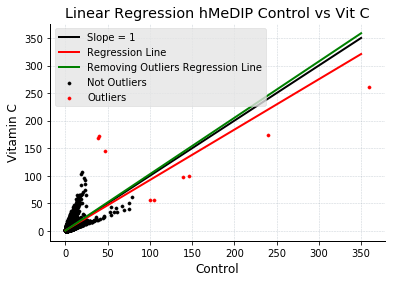

In [28]:
#outliers = ARPE_hMeDIP_outliers["VitC_Average"].values
fig, tmp = plt.subplots()
ax = ARPE_hMeDIP_removing_outliers.plot.scatter(y = "VitC_Average", x = "Control_Average", 
                                                ax=tmp, color = 'k', label = "Not Outliers", s = 10)
ax.scatter(y = ARPE_hMeDIP_outliers["VitC_Average"], x = ARPE_hMeDIP_outliers["Control_Average"], 
           color = 'r', label="Outliers", s = 10)

x_straight = sc.linspace(0, 350, 10)
y_straight = x_straight # I want this line to be a straight line with a slope of 1

plt.title("Linear Regression hMeDIP Control vs Vit C", color='black')
plt.ylabel("Vitamin C", color='black')
plt.xlabel("Control", color='black')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

parameters = linear_model.params
x = sc.linspace(0, 350, 10)
y = parameters[0] + parameters[1]*x

outliers_removed_model
outlier_parameters = outliers_removed_model.params
#x = sc.linspace(0, 350, 10)
outlier_y = outlier_parameters[0] + outlier_parameters[1]*x


plt.plot(x_straight,y_straight,label="Slope = 1", linewidth=2, color='k')
plt.plot(x,y,label="Regression Line", linewidth=2, color='r')
plt.plot(x,outlier_y,label="Removing Outliers Regression Line", linewidth=2, color='g')
plt.legend(loc='upper left')
plt.savefig(Output_Path+"ARPE_hMeDIP_Finding_Outliers.png", dpi=300) # size above specified at 10x6
plt.show()
#plt.savefig(Output_Path+"ARPE_hMeDIP_Finding_Outliers.png")

In [29]:
ARPE_hMeDIP_outliers

,Control_Average,VitC_Average,Cook_Value,Cook_P_Value
Peak_Name,,,,
ARPE19.Control.peak_270708,239.895165,173.595211,22.258741,2.160615e-10
ARPE19.Control.peak_270862,100.637830,56.921163,1.943017,1.432746e-01
"ARPE19.Control.peak_270867,ARPE19.VitC.peak_240629,ARPE19.VitC.peak_240630",359.854007,261.200986,144.841177,1.434095e-63
ARPE19.Control.peak_474371,146.176601,100.049963,3.946745,1.931947e-02
"ARPE19.Control.peak_474377,ARPE19.VitC.peak_418480,ARPE19.VitC.peak_418483",138.925434,98.594811,2.554068,7.776801e-02
ARPE19.Control.peak_51009,104.848888,56.516194,2.648367,7.076996e-02
"ARPE19.VitC.peak_113252,ARPE19.Control.peak_128282,ARPE19.Control.peak_128286,ARPE19.VitC.peak_113253,ARPE19.Control.peak_128291,ARPE19.Control.peak_128295",39.970491,172.713601,4.033975,1.770573e-02
"ARPE19.VitC.peak_249944,ARPE19.Control.peak_280823,ARPE19.Control.peak_280828,ARPE19.Control.peak_280829,ARPE19.Control.peak_280836,ARPE19.Control.peak_280838",38.139755,168.780620,3.537207,2.909689e-02
"ARPE19.VitC.peak_249949,ARPE19.Control.peak_280852,ARPE19.Control.peak_280853,ARPE19.VitC.peak_249950,ARPE19.Control.peak_280854",46.788909,144.135963,3.087665,4.561123e-02


In [30]:
remove_outliers = ARPE_hMeDIP_raw.drop(ARPE_hMeDIP_outliers.index, axis = 0)
total_counts_removing_outliers = remove_outliers.sum(axis=0)

In [31]:
total_counts_removing_outliers

ARPE19_Control_1_IP               7.218338e+07
ARPE19_Control_2_IP               7.816636e+07
ARPE19_LAA_1_IP                   5.855818e+07
ARPE19_LAA_2_IP                   6.731683e+07
ARPE19_Control_1_IP_First_RCPM    9.987482e+05
ARPE19_Control_2_IP_First_RCPM    9.988213e+05
ARPE19_LAA_1_IP_First_RCPM        9.988016e+05
ARPE19_LAA_2_IP_First_RCPM        9.987334e+05
Control_Average                   9.987848e+05
VitC_Average                      9.987675e+05
dtype: float64

In [32]:
# LAA means Vitamin C. I am changing the name out for VitC because more people will recognize it
ARPE_hMeDIP_raw["Control_1_Corrected_RCPM"]= ARPE_hMeDIP_raw["ARPE19_Control_1_IP"]*1000000/total_counts_removing_outliers[0]
ARPE_hMeDIP_raw["Control_2_Corrected_RCPM"]= ARPE_hMeDIP_raw["ARPE19_Control_2_IP"]*1000000/total_counts_removing_outliers[1]
ARPE_hMeDIP_raw["VitC_1_Corrected_RCPM"]= ARPE_hMeDIP_raw["ARPE19_LAA_1_IP"]*1000000/total_counts_removing_outliers[2]
ARPE_hMeDIP_raw["VitC_2_Corrected_RCPM"]= ARPE_hMeDIP_raw["ARPE19_LAA_2_IP"]*1000000/total_counts_removing_outliers[3]


In [33]:
ARPE_hMeDIP_Corrected_RCPM = ARPE_hMeDIP_raw[["Control_1_Corrected_RCPM", "Control_2_Corrected_RCPM", "VitC_1_Corrected_RCPM", "VitC_2_Corrected_RCPM"]].drop(columns_added_by_htseq, axis = 0)

In [34]:
len(ARPE_hMeDIP_Corrected_RCPM)

150899

In [35]:
ARPE_hMeDIP_Corrected_RCPM.head()

,Control_1_Corrected_RCPM,Control_2_Corrected_RCPM,VitC_1_Corrected_RCPM,VitC_2_Corrected_RCPM
Peak_Name,,,,
ARPE19.Control.peak_10,2.271991,2.098089,1.793089,1.025004
ARPE19.Control.peak_100033,1.052874,1.189770,0.939237,0.564495
ARPE19.Control.peak_10005,2.479795,2.136469,1.690626,0.460509
ARPE19.Control.peak_100056,1.108288,1.343289,1.127084,0.846742
ARPE19.Control.peak_10006,1.496189,1.432842,1.161238,0.460509


In [36]:
ARPE_hMeDIP_Corrected_RCPM.to_csv(Output_Path+"ARPE_hMeDIP_RCPM_table.csv")

Now I officially have excluded outliers from the normalization and made the read counts per million. The next step is to divide by length and multiply by 1000 to get "Fragments per Kilobase per Million", also known as FPKM. 
I have the bed file that has the info about peak length for this.

In [37]:
ARPE_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3, names=["Chromosome", "Start", "Stop", "Peak_Name"], dtype = {"Chromosome" : 'str', "Start" : 'int', "Stop" : 'int', "Peak_Name" : 'str'})

In [38]:
len(ARPE_hMeDIP_bed)

150899

In [39]:
ARPE_hMeDIP_bed["Width"] = (ARPE_hMeDIP_bed["Stop"] - ARPE_hMeDIP_bed["Start"] + 1)

In [40]:
ARPE_hMeDIP_bed.dtypes

Chromosome    object
Start          int64
Stop           int64
Width          int64
dtype: object

In [41]:
ARPE_hMeDIP_bed.head()

,Chromosome,Start,Stop,Width
Peak_Name,,,,
ARPE19.Control.peak_6,1,629048,629473,426
ARPE19.Control.peak_7,1,630028,630831,804
ARPE19.Control.peak_8,1,631355,631872,518
ARPE19.Control.peak_10,1,633524,633939,416
ARPE19.VitC.peak_14,1,790268,791584,1317


In [42]:
ARPE_hMeDIP_Corrected_RCPM.head()

,Control_1_Corrected_RCPM,Control_2_Corrected_RCPM,VitC_1_Corrected_RCPM,VitC_2_Corrected_RCPM
Peak_Name,,,,
ARPE19.Control.peak_10,2.271991,2.098089,1.793089,1.025004
ARPE19.Control.peak_100033,1.052874,1.189770,0.939237,0.564495
ARPE19.Control.peak_10005,2.479795,2.136469,1.690626,0.460509
ARPE19.Control.peak_100056,1.108288,1.343289,1.127084,0.846742
ARPE19.Control.peak_10006,1.496189,1.432842,1.161238,0.460509


In [43]:
ARPE_hMeDIP_Corrected_RCPM = ARPE_hMeDIP_Corrected_RCPM.join(ARPE_hMeDIP_bed)

In [44]:
ARPE_hMeDIP_Corrected_RCPM.head()

,Control_1_Corrected_RCPM,Control_2_Corrected_RCPM,VitC_1_Corrected_RCPM,VitC_2_Corrected_RCPM,Chromosome,Start,Stop,Width
Peak_Name,,,,,,,,
ARPE19.Control.peak_10,2.271991,2.098089,1.793089,1.025004,1,633524,633939,416
ARPE19.Control.peak_100033,1.052874,1.189770,0.939237,0.564495,12,53077462,53078125,664
ARPE19.Control.peak_10005,2.479795,2.136469,1.690626,0.460509,1,37724034,37725151,1118
ARPE19.Control.peak_100056,1.108288,1.343289,1.127084,0.846742,12,53128998,53129677,680
ARPE19.Control.peak_10006,1.496189,1.432842,1.161238,0.460509,1,37725328,37725950,623


In [45]:
ARPE_hMeDIP_Corrected_RCPM["Control_1_FPKM"]= ARPE_hMeDIP_Corrected_RCPM["Control_1_Corrected_RCPM"]*1000/ARPE_hMeDIP_Corrected_RCPM["Width"]
ARPE_hMeDIP_Corrected_RCPM["Control_2_FPKM"]= ARPE_hMeDIP_Corrected_RCPM["Control_2_Corrected_RCPM"]*1000/ARPE_hMeDIP_Corrected_RCPM["Width"]
ARPE_hMeDIP_Corrected_RCPM["VitC_1_FPKM"]= ARPE_hMeDIP_Corrected_RCPM["VitC_1_Corrected_RCPM"]*1000/ARPE_hMeDIP_Corrected_RCPM["Width"]
ARPE_hMeDIP_Corrected_RCPM["VitC_2_FPKM"]= ARPE_hMeDIP_Corrected_RCPM["VitC_2_Corrected_RCPM"]*1000/ARPE_hMeDIP_Corrected_RCPM["Width"]


In [46]:
ARPE_hMeDIP_Corrected_RCPM.head()

,Control_1_Corrected_RCPM,Control_2_Corrected_RCPM,VitC_1_Corrected_RCPM,VitC_2_Corrected_RCPM,Chromosome,Start,Stop,Width,Control_1_FPKM,Control_2_FPKM,VitC_1_FPKM,VitC_2_FPKM
Peak_Name,,,,,,,,,,,,
ARPE19.Control.peak_10,2.271991,2.098089,1.793089,1.025004,1,633524,633939,416,5.461517,5.043484,4.310309,2.463951
ARPE19.Control.peak_100033,1.052874,1.189770,0.939237,0.564495,12,53077462,53078125,664,1.585653,1.791823,1.414513,0.850143
ARPE19.Control.peak_10005,2.479795,2.136469,1.690626,0.460509,1,37724034,37725151,1118,2.218064,1.910974,1.512188,0.411904
ARPE19.Control.peak_100056,1.108288,1.343289,1.127084,0.846742,12,53128998,53129677,680,1.629836,1.975425,1.657477,1.245209
ARPE19.Control.peak_10006,1.496189,1.432842,1.161238,0.460509,1,37725328,37725950,623,2.401588,2.299906,1.863946,0.739180


In [47]:
ARPE_hMeDIP_FPKM_table = ARPE_hMeDIP_Corrected_RCPM[["Control_1_FPKM", "Control_2_FPKM", "VitC_1_FPKM", "VitC_2_FPKM"]]

In [48]:
ARPE_hMeDIP_FPKM_table.to_csv(Output_Path+"ARPE_hMeDIP_FPKM_table.csv")
ARPE_hMeDIP_FPKM_table.to_pickle(Output_Path+"ARPE_hMeDIP_FPKM_table.pkl")

Now I have the FPKM values calculated correctly. Next I need to figure out which ones go up, which ones go down, and which ones don't change. I am going to use a fold change cutoff of 1.5X and a corrected P-value from edgeR cutoff of 0.05. 

In [49]:
ARPE_hMeDIP_FPKM_table = pd.read_pickle(Output_Path+"ARPE_hMeDIP_FPKM_table.pkl")

In [50]:
ARPE_hMeDIP_FPKM_table["Control_Average_FPKM"] = ARPE_hMeDIP_FPKM_table[["Control_1_FPKM", "Control_2_FPKM"]].mean(axis=1)
ARPE_hMeDIP_FPKM_table["VitC_Average_FPKM"] = ARPE_hMeDIP_FPKM_table[["VitC_1_FPKM", "VitC_2_FPKM"]].mean(axis=1)
ARPE_hMeDIP_FPKM_table["Fold_Change"] =  (ARPE_hMeDIP_FPKM_table["VitC_Average_FPKM"])/(ARPE_hMeDIP_FPKM_table["Control_Average_FPKM"])
ARPE_hMeDIP_FPKM_table["Log2FC"] = np.log2(ARPE_hMeDIP_FPKM_table["Fold_Change"])
# All 4 of these return warnings, if you have run this before because you are replacing the old values with new ones (which are the same as the old)

In [51]:
ARPE_hMeDIP_FPKM_table.tail()

,Control_1_FPKM,Control_2_FPKM,VitC_1_FPKM,VitC_2_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC
Peak_Name,,,,,,,,
ARPE19.VitC.peak_99985,0.898731,1.072850,1.594217,2.914613,0.985790,2.254415,2.286912,1.193401
"ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631",1.976472,1.622391,3.631972,6.259954,1.799431,4.945963,2.748625,1.458710
ARPE19.VitC.peak_99988,0.992986,0.916982,2.745160,4.465841,0.954984,3.605501,3.775457,1.916651
ARPE19.VitC.peak_99990,1.041791,0.695952,2.459093,4.943786,0.868871,3.701439,4.260055,2.090872
ARPE19.VitC.peak_99994,0.851594,0.814498,2.174463,3.783083,0.833046,2.978773,3.575763,1.838251


In [52]:
ARPE_hMeDIP_edgeR = pd.read_csv(Input_hMeDIP_edgeR, sep = ",", index_col=0)


In [53]:
ARPE_hMeDIP_edgeR.head()

,logFC,logCPM,LR,PValue,FDR
Feature,,,,,
ARPE19.VitC.peak_246232,-3.161988,2.436264,44.839863,2.140000e-11,0.000003
ARPE19.VitC.peak_286485,-3.945334,0.419847,42.618735,6.650000e-11,0.000003
ARPE19.VitC.peak_401356,-3.194091,1.826464,42.398974,7.440000e-11,0.000003
ARPE19.VitC.peak_113284,-3.169597,2.589791,42.041794,8.930000e-11,0.000003
ARPE19.VitC.peak_106755,-3.269852,1.515476,41.837537,9.920000e-11,0.000003


In [54]:
ARPE_hMeDIP_FPKM_table = ARPE_hMeDIP_FPKM_table.join(ARPE_hMeDIP_edgeR)

In [55]:
ARPE_hMeDIP_FPKM_table = ARPE_hMeDIP_FPKM_table.drop(["logFC", "logCPM", "LR", "PValue"], axis = 1)

In [56]:
# There has to be a faster way to do this than looping through the whole thing manually, 
# but this is the only way I know how to do it.
list_of_conditions = []
i = 0
while i < len(ARPE_hMeDIP_FPKM_table):
    if ARPE_hMeDIP_FPKM_table["FDR"][i] < 0.05:
        if ARPE_hMeDIP_FPKM_table["Log2FC"][i] >= 0.584962500721156:
            list_of_conditions.append("Upregulated")
            i += 1
        elif ARPE_hMeDIP_FPKM_table["Log2FC"][i] <= -0.584962500721156:
            list_of_conditions.append("Downregulated")
            i += 1
        else:
            list_of_conditions.append("Nondifferential")
            i += 1
    else:
        list_of_conditions.append("Nondifferential")
        i += 1
    
        

In [57]:
ARPE_hMeDIP_FPKM_table["Change"] = list_of_conditions

In [58]:
ARPE_hMeDIP_FPKM_table.head(12)

,Control_1_FPKM,Control_2_FPKM,VitC_1_FPKM,VitC_2_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC,FDR,Change
Peak_Name,,,,,,,,,,
ARPE19.Control.peak_10,5.461517,5.043484,4.310309,2.463951,5.252500,3.387130,0.644861,-0.632941,0.206001,Nondifferential
ARPE19.Control.peak_100033,1.585653,1.791823,1.414513,0.850143,1.688738,1.132328,0.670517,-0.576654,0.309121,Nondifferential
ARPE19.Control.peak_10005,2.218064,1.910974,1.512188,0.411904,2.064519,0.962046,0.465991,-1.101628,0.086925,Nondifferential
ARPE19.Control.peak_100056,1.629836,1.975425,1.657477,1.245209,1.802630,1.451343,0.805125,-0.312715,0.555010,Nondifferential
ARPE19.Control.peak_10006,2.401588,2.299906,1.863946,0.739180,2.350747,1.301563,0.553681,-0.852874,0.155778,Nondifferential
ARPE19.Control.peak_10007,3.353452,3.046007,2.078158,0.668088,3.199729,1.373123,0.429137,-1.220489,0.052040,Nondifferential
"ARPE19.Control.peak_100074,ARPE19.VitC.peak_88733",1.474651,1.465891,1.984538,3.060968,1.470271,2.522753,1.715842,0.778917,0.087862,Nondifferential
ARPE19.Control.peak_100079,3.955726,3.811085,1.857576,1.120102,3.883406,1.488839,0.383385,-1.383135,0.008371,Downregulated
ARPE19.Control.peak_100081,2.483955,2.517618,2.265321,1.602448,2.500786,1.933884,0.773310,-0.370880,0.451972,Nondifferential


Now I need to read in the region_analysis to put each peak with a gene or region of a gene

In [59]:
ARPE_region_analysis = pd.read_csv(Input_region_analysis, sep = "\t", index_col=3)

In [60]:
dave_region = []
i = 0
while i < len(ARPE_region_analysis):
    if ARPE_region_analysis["Distance from TSS"][i] >= -3000 and ARPE_region_analysis["Distance from TSS"][i] < -250:
        dave_region.append("Upstream_Promoter")
        i += 1
    elif ARPE_region_analysis["Distance from TSS"][i] >= -250 and ARPE_region_analysis["Distance from TSS"][i] <= 250:
        dave_region.append("TSS")
        i += 1
    elif ARPE_region_analysis["Distance from TSS"][i] > 250 and ARPE_region_analysis["Distance from TSS"][i] <= 3000:
        dave_region.append("Downstream_Promoter")
        i += 1
    elif ARPE_region_analysis["Distance from TSS"][i] > 3000:
        dave_region.append("Gene_Body")
        i += 1
    else:
        dave_region.append("Intergenic")
        i += 1

In [61]:
ARPE_region_analysis["Gene_Region"] = dave_region

In [62]:
ARPE_region_analysis_cleaned = ARPE_region_analysis[["Gene ID", "Gene_Region", "Distance from TSS"]]

In [63]:
ARPE_region_analysis_cleaned.head()

,Gene ID,Gene_Region,Distance from TSS
Name,,,
ARPE19.Control.peak_100056,ENSG00000258074,Upstream_Promoter,-2013.0
ARPE19.Control.peak_100107,ENSG00000283536,Upstream_Promoter,-394.0
ARPE19.Control.peak_100232,NaN,Intergenic,NaN
ARPE19.Control.peak_100239,NaN,Intergenic,NaN
ARPE19.Control.peak_100241,NaN,Intergenic,NaN


In [64]:
ARPE_hMeDIP_FPKM_table = ARPE_hMeDIP_FPKM_table.join(ARPE_region_analysis_cleaned)

In [65]:
ARPE_hMeDIP_FPKM_table.head()

,Control_1_FPKM,Control_2_FPKM,VitC_1_FPKM,VitC_2_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC,FDR,Change,Gene ID,Gene_Region,Distance from TSS
Peak_Name,,,,,,,,,,,,,
ARPE19.Control.peak_10,5.461517,5.043484,4.310309,2.463951,5.252500,3.387130,0.644861,-0.632941,0.206001,Nondifferential,ENSG00000278791,Upstream_Promoter,-1318.0
ARPE19.Control.peak_100033,1.585653,1.791823,1.414513,0.850143,1.688738,1.132328,0.670517,-0.576654,0.309121,Nondifferential,ENSG00000167778,Downstream_Promoter,1584.0
ARPE19.Control.peak_10005,2.218064,1.910974,1.512188,0.411904,2.064519,0.962046,0.465991,-1.101628,0.086925,Nondifferential,ENSG00000183317,Upstream_Promoter,-2735.0
ARPE19.Control.peak_100056,1.629836,1.975425,1.657477,1.245209,1.802630,1.451343,0.805125,-0.312715,0.555010,Nondifferential,ENSG00000258074,Upstream_Promoter,-2013.0
ARPE19.Control.peak_10006,2.401588,2.299906,1.863946,0.739180,2.350747,1.301563,0.553681,-0.852874,0.155778,Nondifferential,ENSG00000183317,Gene_Body,5855.0


Now I have to figure out how to sum the counts per gene for both location and change

In [66]:
cleanup = ARPE_hMeDIP_FPKM_table[["Change", "Gene ID", "Gene_Region"]]

In [67]:
summed_counts = pd.DataFrame(cleanup.groupby(["Gene ID", "Gene_Region", "Change"], as_index = False).size().unstack().unstack())

In [68]:
summed_counts.tail()

Change          Downregulated                                                  \
Gene_Region               TSS Downstream_Promoter Gene_Body Upstream_Promoter   
Gene ID                                                                         
ENSG00000284513           NaN                 NaN       NaN               NaN   
ENSG00000284516           NaN                 NaN       NaN               NaN   
ENSG00000284523           NaN                 NaN       NaN               NaN   
ENSG00000284543           NaN                 NaN       NaN               NaN   
ENSG00000284572           NaN                 1.0       NaN               1.0   

Change          Nondifferential                                \
Gene_Region                 TSS Downstream_Promoter Gene_Body   
Gene ID                                                         
ENSG00000284513             NaN                 NaN       NaN   
ENSG00000284516             NaN                 NaN       2.0   
ENSG00000284523             NaN                 NaN       2.0   
ENSG00000284543             1.0                 NaN       1.0   
ENSG00000284572             NaN                 NaN       NaN   

Change                            Upregulated                                \
Gene_Region     Upstream_Promoter         TSS Downstream_Promoter Gene_Body   
Gene ID                                                                       
ENSG00000284513               1.0         NaN                 NaN       NaN   
ENSG00000284516               1.0         NaN                 NaN       NaN   
ENSG00000284523               NaN         NaN                 NaN       NaN   
ENSG00000284543               2.0         NaN                 NaN       2.0   
ENSG00000284572               NaN         NaN                 NaN       NaN   

Change                             
Gene_Region     Upstream_Promoter  
Gene ID                            
ENSG00000284513               NaN  
ENSG00000284516               NaN  
ENSG00000284523               NaN  
ENSG00000284543               NaN  
ENSG00000284572               NaN

In [69]:
summed_counts.columns = [ "TSS_Downregulated", "Downstream_Promoter_Downregulated", 
               "Gene_Body_Downregulated", "Upstream_Promoter_Downregulated",
              "TSS_Nondifferential", "Downstream_Promoter_Nondifferential", "Gene_Body_Nondifferential",
              "Upstream_Promoter_Nondifferential", "TSS_Upregulated", "Downstream_Promoter_Upregulated",
              "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated"]

In [70]:
summed_counts = summed_counts.fillna(0)

In [71]:
summed_counts.head()

,TSS_Downregulated,Downstream_Promoter_Downregulated,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,TSS_Nondifferential,Downstream_Promoter_Nondifferential,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,TSS_Upregulated,Downstream_Promoter_Upregulated,Gene_Body_Upregulated,Upstream_Promoter_Upregulated
Gene ID,,,,,,,,,,,,
ENSG00000000003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000005,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ENSG00000000457,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
ENSG00000000460,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0


In [72]:
summed_counts.to_csv(Output_Path+"ARPE_Counts_of_peaks_per_region.csv")
summed_counts.to_pickle(Output_Path+"ARPE_Counts_of_peaks_per_region.pkl")

### Moving on to the RNA-seq data
Now I have officially gotten the hMeDIP-seq info cleaned up (removed outliers) and normalized correctly, then converted it to FPKM using the width of the peaks (from the bed file). Next I was able to get the counts of peaks within each gene region for each annotated gene. 

The next step is to normalize the RNA-seq data similar to the way we did for the hMeDIP-seq, except removing the htseq-count lines before the first RCPM. This again requires finding outliers for correct normalization and using the length of each gene (exonic length, not total genomic length) to calculate the FPKM values. 

In [73]:
ARPE_Raw_RNA_data = pd.read_csv(Input_RNA_Counts_File, sep = "\t", index_col=0)

In [74]:
ARPE_Raw_RNA_data.head()

,Control_01,Control_02,Control_03,VitC_01,VitC_02,VitC_03
Ensembl_ID,,,,,,
ENSG00000000003,2341,2174,1862,2113,2658,2188
ENSG00000000005,0,0,3,1,0,0
ENSG00000000419,2161,1846,1407,2644,2607,2714
ENSG00000000457,779,666,517,1090,1218,1101
ENSG00000000460,302,294,200,462,569,487


In [75]:
# For this one I need to remove the HTSeq columns before I normalize because unmapped reads will interefere with RNA counts
ARPE_Raw_RNA_data = ARPE_Raw_RNA_data.drop(columns_added_by_htseq, axis = 0)

In [76]:
total_counts_ARPE_RNA_Raw = ARPE_Raw_RNA_data.sum(axis=0)

In [77]:
ARPE_Raw_RNA_data["Control_1_first_RCPM"] = ARPE_Raw_RNA_data["Control_01"]*1000000/total_counts_ARPE_RNA_Raw[0]
ARPE_Raw_RNA_data["Control_2_first_RCPM"] = ARPE_Raw_RNA_data["Control_02"]*1000000/total_counts_ARPE_RNA_Raw[1]
ARPE_Raw_RNA_data["Control_3_first_RCPM"] = ARPE_Raw_RNA_data["Control_03"]*1000000/total_counts_ARPE_RNA_Raw[2]
ARPE_Raw_RNA_data["VitC_1_first_RCPM"] = ARPE_Raw_RNA_data["VitC_01"]*1000000/total_counts_ARPE_RNA_Raw[3]
ARPE_Raw_RNA_data["VitC_2_first_RCPM"] = ARPE_Raw_RNA_data["VitC_02"]*1000000/total_counts_ARPE_RNA_Raw[4]
ARPE_Raw_RNA_data["VitC_3_first_RCPM"] = ARPE_Raw_RNA_data["VitC_03"]*1000000/total_counts_ARPE_RNA_Raw[5]
ARPE_Raw_RNA_data["Control_Average"] = ARPE_Raw_RNA_data[["Control_1_first_RCPM", "Control_2_first_RCPM", "Control_3_first_RCPM"]].mean(axis=1)
ARPE_Raw_RNA_data["VitC_Average"] = ARPE_Raw_RNA_data[["VitC_1_first_RCPM", "VitC_2_first_RCPM", "VitC_3_first_RCPM"]].mean(axis=1)


In [78]:
ARPE_Raw_RNA_data.head()

,Control_01,Control_02,Control_03,VitC_01,VitC_02,VitC_03,Control_1_first_RCPM,Control_2_first_RCPM,Control_3_first_RCPM,VitC_1_first_RCPM,VitC_2_first_RCPM,VitC_3_first_RCPM,Control_Average,VitC_Average
Ensembl_ID,,,,,,,,,,,,,,
ENSG00000000003,2341,2174,1862,2113,2658,2188,73.451970,81.428143,82.692360,48.785919,57.393791,46.314531,79.190824,50.831413
ENSG00000000005,0,0,3,1,0,0,0.000000,0.000000,0.133232,0.023088,0.000000,0.000000,0.044411,0.007696
ENSG00000000419,2161,1846,1407,2644,2607,2714,67.804232,69.142756,62.485580,61.045892,56.292555,57.448646,66.477523,58.262364
ENSG00000000457,779,666,517,1090,1218,1101,24.442155,24.945328,22.960231,25.166423,26.300089,23.305438,24.115905,24.923983
ENSG00000000460,302,294,200,462,569,487,9.475649,11.011902,8.882101,10.666869,12.286331,10.308582,9.789884,11.087260


In [79]:
ARPE_RNA_first_RCPM_averages = ARPE_Raw_RNA_data[["Control_Average","VitC_Average" ]]

In [80]:
ARPE_RNA_first_RCPM_averages.head()

,Control_Average,VitC_Average
Ensembl_ID,,
ENSG00000000003,79.190824,50.831413
ENSG00000000005,0.044411,0.007696
ENSG00000000419,66.477523,58.262364
ENSG00000000457,24.115905,24.923983
ENSG00000000460,9.789884,11.087260


In [81]:
ARPE_RNA_first_RCPM_averages.describe()

,Control_Average,VitC_Average
count,58302.000000,58302.000000
mean,17.152070,17.152070
std,174.253684,159.487316
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.014804,0.007696
75%,0.754794,0.720653
max,24771.026905,19213.144253


In [82]:
ARPE_RNA_first_RCPM_averages.quantile([0.7, 0.75, 0.8, 0.9, 0.95])

,Control_Average,VitC_Average
0.70,0.280497,0.224778
0.75,0.754794,0.720653
0.80,2.669311,3.092747
0.90,26.750672,30.463031
0.95,73.355588,77.819200


Well, this describe function wasn't as useful as I had hoped it would be. I forgot that the human genome has many annotated transcripts that are only coding in one or two cell types and only during some points of development, so almost half of these have an average value of 0 for both control and vitamin C. 
<br>When I look at quantiles closer to 1 I get something useful. The 70% and 75%look quite close, which is a good sign that they aren't completely different like cells from another tissue or a different animal type. The lower percentiles have lower values in Vitamin C and the higher percentiles have lower values in Control, but the standard deviation is larger for control than Vit C. I am not quite sure what to think of that.

Anyways, the next step is to identify outliers and re-normalize without those ones.

In [83]:
linear_model_RNA = sm.ols(formula="VitC_Average ~ Control_Average", data=ARPE_RNA_first_RCPM_averages).fit()
linear_model_RNA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                 3.196e+05
Date:                Wed, 27 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:46:49   Log-Likelihood:            -3.2395e+05
No. Observations:               58302   AIC:                         6.479e+05
Df Residuals:                   58300   BIC:                         6.479e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.7151      0.261     10.415      0.000       2.204       3.226
Control_Average     0.8417      0.001    565.339      0.000       0.839       0.845
==============================================================================
Omnibus:                   159355.920   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     146749020512.351
Skew:                          32.758   Prob(JB):                         0.00
Kurtosis:                    7775.059   Cond. No.                         176.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
influence_RNA = linear_model_RNA.get_influence()
(cook,p_cook) = influence_RNA.cooks_distance
ARPE_RNA_first_RCPM_averages["Cook_Value"] = cook
ARPE_RNA_first_RCPM_averages["Cook_P_Value"] = p_cook

/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [85]:
ARPE_RNA_first_RCPM_averages.head()

,Control_Average,VitC_Average,Cook_Value,Cook_P_Value
Ensembl_ID,,,,
ENSG00000000003,79.190824,50.831413,8.463777e-07,0.999999
ENSG00000000005,0.044411,0.007696,1.662407e-08,1.000000
ENSG00000000419,66.477523,58.262364,3.914203e-10,1.000000
ENSG00000000457,24.115905,24.923983,7.989313e-09,1.000000
ENSG00000000460,9.789884,11.087260,3.813775e-11,1.000000


In [86]:
ARPE_RNA_removing_outliers = ARPE_RNA_first_RCPM_averages[ARPE_RNA_first_RCPM_averages.Cook_Value <= 1]
ARPE_RNA_outliers = ARPE_RNA_first_RCPM_averages[ARPE_RNA_first_RCPM_averages.Cook_Value > 1]

In [87]:
ARPE_RNA_outliers

,Control_Average,VitC_Average,Cook_Value,Cook_P_Value
Ensembl_ID,,,,
ENSG00000060718,5793.725818,2790.084590,10.900452,1.848752e-05
ENSG00000100345,2084.471641,4652.005763,2.608698,7.363895e-02
ENSG00000115414,12873.497403,19213.144253,1015.312136,0.000000e+00
ENSG00000120708,10618.959970,6162.278986,71.231158,1.266008e-31
ENSG00000137801,24771.026905,18824.616019,424.307089,1.132519e-183
ENSG00000140416,4057.067566,4637.622411,1.784667,1.678621e-01
ENSG00000146674,10234.537861,2562.511654,311.160730,3.808633e-135
ENSG00000150093,7085.456519,4614.072724,6.970176,9.402703e-04
ENSG00000163453,7582.533524,7094.135984,2.213780,1.092960e-01


In [88]:
outliers_removed_model_RNA = sm.ols(formula="VitC_Average ~ Control_Average", data=ARPE_RNA_removing_outliers).fit()
outliers_removed_model_RNA.summary()
# This one has a slightly higher R-squared value. 
# Now I want to see what it looks like in the graph. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                 3.658e+05
Date:                Wed, 27 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:46:49   Log-Likelihood:            -2.8739e+05
No. Observations:               58290   AIC:                         5.748e+05
Df Residuals:                   58288   BIC:                         5.748e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.1508      0.141     15.306      0.000       1.875       2.426
Control_Average     0.8753      0.001    604.815      0.000       0.873       0.878
==============================================================================
Omnibus:                    98184.168   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2216520040.581
Skew:                          10.273   Prob(JB):                         0.00
Kurtosis:                     958.089   Cond. No.                         98.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

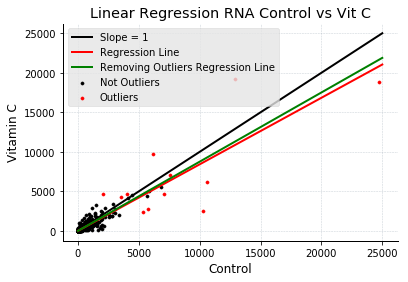

In [89]:
#outliers = ARPE_hMeDIP_outliers["VitC_Average"].values
fig, tmp = plt.subplots()
ax = ARPE_RNA_removing_outliers.plot.scatter(y = "VitC_Average", x = "Control_Average", 
                                                ax=tmp, color = 'k', label = "Not Outliers", s = 10)
ax.scatter(y = ARPE_RNA_outliers["VitC_Average"], x = ARPE_RNA_outliers["Control_Average"], 
           color = 'r', label="Outliers", s = 10)

x_straight = sc.linspace(0, 25000, 10)
y_straight = x_straight # I want this line to be a straight line with a slope of 1

plt.title("Linear Regression RNA Control vs Vit C", color='black')
plt.ylabel("Vitamin C", color='black')
plt.xlabel("Control", color='black')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

parameters = linear_model_RNA.params
x = sc.linspace(0, 25000, 10)
y = parameters[0] + parameters[1]*x


outlier_parameters = outliers_removed_model_RNA.params
#x = sc.linspace(0, 350, 10)
outlier_y = outlier_parameters[0] + outlier_parameters[1]*x


plt.plot(x_straight,y_straight,label="Slope = 1", linewidth=2, color='k')
plt.plot(x,y,label="Regression Line", linewidth=2, color='r')
plt.plot(x,outlier_y,label="Removing Outliers Regression Line", linewidth=2, color='g')
plt.legend(loc='upper left')
plt.savefig(Output_Path+"ARPE_RNA_Finding_Outliers.png", dpi=300) # size above specified at 10x6
plt.show()


I was surprised to find that removing the outliers didn't shift it that much closer to a slope of 1. 

In [90]:
print(len(ARPE_RNA_removing_outliers))
print(len(ARPE_Raw_RNA_data))
# Difference of 12, which is the number of outliers

58290
58302


In [91]:
remove_outliers_RNA = ARPE_Raw_RNA_data.drop(ARPE_RNA_outliers.index, axis = 0)


In [92]:
total_counts_removing_outliers_RNA = remove_outliers_RNA.sum(axis=0)

In [93]:
total_counts_removing_outliers_RNA

Control_01              2.862680e+07
Control_02              2.412137e+07
Control_03              2.021727e+07
VitC_01                 3.962444e+07
VitC_02                 4.227887e+07
VitC_03                 4.305366e+07
Control_1_first_RCPM    8.982035e+05
Control_2_first_RCPM    9.034767e+05
Control_3_first_RCPM    8.978593e+05
VitC_1_first_RCPM       9.148672e+05
VitC_2_first_RCPM       9.129213e+05
VitC_3_first_RCPM       9.113391e+05
Control_Average         8.998465e+05
VitC_Average            9.130425e+05
dtype: float64

In [94]:
ARPE_Raw_RNA_data.head()

,Control_01,Control_02,Control_03,VitC_01,VitC_02,VitC_03,Control_1_first_RCPM,Control_2_first_RCPM,Control_3_first_RCPM,VitC_1_first_RCPM,VitC_2_first_RCPM,VitC_3_first_RCPM,Control_Average,VitC_Average
Ensembl_ID,,,,,,,,,,,,,,
ENSG00000000003,2341,2174,1862,2113,2658,2188,73.451970,81.428143,82.692360,48.785919,57.393791,46.314531,79.190824,50.831413
ENSG00000000005,0,0,3,1,0,0,0.000000,0.000000,0.133232,0.023088,0.000000,0.000000,0.044411,0.007696
ENSG00000000419,2161,1846,1407,2644,2607,2714,67.804232,69.142756,62.485580,61.045892,56.292555,57.448646,66.477523,58.262364
ENSG00000000457,779,666,517,1090,1218,1101,24.442155,24.945328,22.960231,25.166423,26.300089,23.305438,24.115905,24.923983
ENSG00000000460,302,294,200,462,569,487,9.475649,11.011902,8.882101,10.666869,12.286331,10.308582,9.789884,11.087260


In [95]:
ARPE_Raw_RNA_data["Control_1_RCPM"] = ARPE_Raw_RNA_data["Control_01"]*1000000/total_counts_removing_outliers_RNA[0]
ARPE_Raw_RNA_data["Control_2_RCPM"] = ARPE_Raw_RNA_data["Control_02"]*1000000/total_counts_removing_outliers_RNA[1]
ARPE_Raw_RNA_data["Control_3_RCPM"] = ARPE_Raw_RNA_data["Control_03"]*1000000/total_counts_removing_outliers_RNA[2]
ARPE_Raw_RNA_data["VitC_1_RCPM"] = ARPE_Raw_RNA_data["VitC_01"]*1000000/total_counts_removing_outliers_RNA[3]
ARPE_Raw_RNA_data["VitC_2_RCPM"] = ARPE_Raw_RNA_data["VitC_02"]*1000000/total_counts_removing_outliers_RNA[4]
ARPE_Raw_RNA_data["VitC_3_RCPM"] = ARPE_Raw_RNA_data["VitC_03"]*1000000/total_counts_removing_outliers_RNA[5]
ARPE_RNA_Corrected_RCPM = ARPE_Raw_RNA_data[["Control_1_RCPM", "Control_2_RCPM", "Control_3_RCPM", "VitC_1_RCPM", "VitC_2_RCPM", "VitC_3_RCPM"]]

In [96]:
ARPE_RNA_Corrected_RCPM.head()

,Control_1_RCPM,Control_2_RCPM,Control_3_RCPM,VitC_1_RCPM,VitC_2_RCPM,VitC_3_RCPM
Ensembl_ID,,,,,,
ENSG00000000003,81.776531,90.127551,92.099468,53.325681,62.868281,50.820304
ENSG00000000005,0.000000,0.000000,0.148388,0.025237,0.000000,0.000000
ENSG00000000419,75.488716,76.529650,69.593959,66.726503,61.662005,63.037617
ENSG00000000457,27.212267,27.610372,25.572194,27.508279,28.808716,25.572740
ENSG00000000460,10.549557,12.188362,9.892531,11.659472,13.458259,11.311466


In [97]:
ARPE_RNA_Corrected_RCPM.to_csv(Output_Path+"ARPE_RNA_RCPM_table.csv")

In [98]:
Human_Genomic_Info_File = pd.read_csv(Input_genomic_info_file, sep = ",", index_col = 0 )


In [99]:
Human_Genomic_Info_File.dtypes # It looks like I don't need to specify the types because the lengths and positions went in as float

Name                   object
Location               object
Sense                  object
Biotype                object
transcript_id          object
Chr                    object
Start                 float64
Stop                  float64
Length                float64
Exonic Length         float64
Intronic Length       float64
gene_id                object
gene_version          float64
transcript_version    float64
gene_name              object
gene_source            object
gene_biotype           object
transcript_name        object
transcript_source      object
transcript_biotype     object
dtype: object

In [100]:
Human_Genomic_Info_File.head()

,Name,Location,Sense,Biotype,transcript_id,Chr,Start,Stop,Length,Exonic Length,Intronic Length,gene_id,gene_version,transcript_version,gene_name,gene_source,gene_biotype,transcript_name,transcript_source,transcript_biotype
Gene_ID,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,TSPAN6,chrX:100627109-100639991,-,protein_coding,ENST00000612152,X,100627109.0,100637104.0,9996.0,3796.0,6200.0,ENSG00000000003,14.0,4.0,TSPAN6,ensembl_havana,protein_coding,TSPAN6-204,ensembl,protein_coding
ENSG00000000005,TNMD,chrX:100584802-100599885,+,protein_coding,ENST00000373031,X,100584802.0,100599885.0,15084.0,1339.0,13745.0,ENSG00000000005,5.0,4.0,TNMD,ensembl_havana,protein_coding,TNMD-201,ensembl_havana,protein_coding
ENSG00000000419,DPM1,chr20:50934867-50958555,-,protein_coding,ENST00000371582,20,50934867.0,50958555.0,23689.0,1161.0,22528.0,ENSG00000000419,12.0,8.0,DPM1,ensembl_havana,protein_coding,DPM1-201,havana,protein_coding
ENSG00000000457,SCYL3,chr1:169849631-169894267,-,protein_coding,ENST00000367771,1,169849631.0,169893952.0,44322.0,6364.0,37958.0,ENSG00000000457,13.0,10.0,SCYL3,ensembl_havana,protein_coding,SCYL3-202,ensembl_havana,protein_coding
ENSG00000000460,C1orf112,chr1:169662007-169854080,+,protein_coding,ENST00000286031,1,169795409.0,169854080.0,58672.0,4355.0,54317.0,ENSG00000000460,16.0,10.0,C1orf112,ensembl_havana,protein_coding,C1orf112-201,ensembl_havana,protein_coding


In [101]:
ARPE_RNA_Corrected_RCPM = ARPE_RNA_Corrected_RCPM.join(Human_Genomic_Info_File)

In [102]:
ARPE_RNA_Corrected_RCPM.head()

,Control_1_RCPM,Control_2_RCPM,Control_3_RCPM,VitC_1_RCPM,VitC_2_RCPM,VitC_3_RCPM,Name,Location,Sense,Biotype,...,Intronic Length,gene_id,gene_version,transcript_version,gene_name,gene_source,gene_biotype,transcript_name,transcript_source,transcript_biotype
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,81.776531,90.127551,92.099468,53.325681,62.868281,50.820304,TSPAN6,chrX:100627109-100639991,-,protein_coding,...,6200.0,ENSG00000000003,14.0,4.0,TSPAN6,ensembl_havana,protein_coding,TSPAN6-204,ensembl,protein_coding
ENSG00000000005,0.000000,0.000000,0.148388,0.025237,0.000000,0.000000,TNMD,chrX:100584802-100599885,+,protein_coding,...,13745.0,ENSG00000000005,5.0,4.0,TNMD,ensembl_havana,protein_coding,TNMD-201,ensembl_havana,protein_coding
ENSG00000000419,75.488716,76.529650,69.593959,66.726503,61.662005,63.037617,DPM1,chr20:50934867-50958555,-,protein_coding,...,22528.0,ENSG00000000419,12.0,8.0,DPM1,ensembl_havana,protein_coding,DPM1-201,havana,protein_coding
ENSG00000000457,27.212267,27.610372,25.572194,27.508279,28.808716,25.572740,SCYL3,chr1:169849631-169894267,-,protein_coding,...,37958.0,ENSG00000000457,13.0,10.0,SCYL3,ensembl_havana,protein_coding,SCYL3-202,ensembl_havana,protein_coding
ENSG00000000460,10.549557,12.188362,9.892531,11.659472,13.458259,11.311466,C1orf112,chr1:169662007-169854080,+,protein_coding,...,54317.0,ENSG00000000460,16.0,10.0,C1orf112,ensembl_havana,protein_coding,C1orf112-201,ensembl_havana,protein_coding


In [103]:
ARPE_RNA_Corrected_RCPM["Control_1_FPKM"]= ARPE_RNA_Corrected_RCPM["Control_1_RCPM"]*1000/ARPE_RNA_Corrected_RCPM["Exonic Length"]
ARPE_RNA_Corrected_RCPM["Control_2_FPKM"]= ARPE_RNA_Corrected_RCPM["Control_2_RCPM"]*1000/ARPE_RNA_Corrected_RCPM["Exonic Length"]
ARPE_RNA_Corrected_RCPM["Control_3_FPKM"]= ARPE_RNA_Corrected_RCPM["Control_3_RCPM"]*1000/ARPE_RNA_Corrected_RCPM["Exonic Length"]

ARPE_RNA_Corrected_RCPM["VitC_1_FPKM"]= ARPE_RNA_Corrected_RCPM["VitC_1_RCPM"]*1000/ARPE_RNA_Corrected_RCPM["Exonic Length"]
ARPE_RNA_Corrected_RCPM["VitC_2_FPKM"]= ARPE_RNA_Corrected_RCPM["VitC_2_RCPM"]*1000/ARPE_RNA_Corrected_RCPM["Exonic Length"]
ARPE_RNA_Corrected_RCPM["VitC_3_FPKM"]= ARPE_RNA_Corrected_RCPM["VitC_3_RCPM"]*1000/ARPE_RNA_Corrected_RCPM["Exonic Length"]


In [104]:
#ARPE_RNA_Corrected_RCPM.head()
ARPE_RNA_FPKM_table = ARPE_RNA_Corrected_RCPM[["Control_1_FPKM", "Control_2_FPKM", "Control_3_FPKM", "VitC_1_FPKM", "VitC_2_FPKM", "VitC_3_FPKM"]]

In [105]:
ARPE_RNA_FPKM_table.head()

,Control_1_FPKM,Control_2_FPKM,Control_3_FPKM,VitC_1_FPKM,VitC_2_FPKM,VitC_3_FPKM
Ensembl_ID,,,,,,
ENSG00000000003,21.542816,23.742769,24.262241,14.047861,16.561718,13.387857
ENSG00000000005,0.000000,0.000000,0.110820,0.018848,0.000000,0.000000
ENSG00000000419,65.020427,65.917011,59.943117,57.473302,53.111115,54.295966
ENSG00000000457,4.275969,4.338525,4.018258,4.322483,4.526825,4.018344
ENSG00000000460,2.422401,2.798705,2.271534,2.677261,3.090301,2.597352


Now I have the FPKM table for the RNA. Next I need to read in the statistical files (edgeR and DESeq2) and calculate fold changes to determine which direction each gene goes. When I did this for the hMeDIP, none of them had values of 0 so I didn't need to worry about dividing by infinity. For this one, I needed to make up a lambda function for an if statement if the values were below 0.1 for both VitC and Control.

In [107]:
ARPE_RNA_FPKM_table["Control_Average_FPKM"] = ARPE_RNA_FPKM_table[["Control_1_FPKM", "Control_2_FPKM", "Control_3_FPKM"]].mean(axis=1)
ARPE_RNA_FPKM_table["VitC_Average_FPKM"] = ARPE_RNA_FPKM_table[["VitC_1_FPKM", "VitC_2_FPKM", "VitC_3_FPKM"]].mean(axis=1)
ARPE_RNA_FPKM_table["Fold_Change"] =  ARPE_RNA_FPKM_table.apply(lambda x: (x["VitC_Average_FPKM"]/x["Control_Average_FPKM"]) if min(x["VitC_Average_FPKM"],x["Control_Average_FPKM"]) > 0.1 else 1, axis = 1)
ARPE_RNA_FPKM_table["Log2FC"] = np.log2(ARPE_RNA_FPKM_table["Fold_Change"])
# All 4 of these return warnings, if you have run this before because you are replacing the old values with new ones (which are the same as the old)

In [108]:
ARPE_RNA_FPKM_table.head()

,Control_1_FPKM,Control_2_FPKM,Control_3_FPKM,VitC_1_FPKM,VitC_2_FPKM,VitC_3_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC
Ensembl_ID,,,,,,,,,,
ENSG00000000003,21.542816,23.742769,24.262241,14.047861,16.561718,13.387857,23.182609,14.665812,0.632621,-0.660586
ENSG00000000005,0.000000,0.000000,0.110820,0.018848,0.000000,0.000000,0.036940,0.006283,1.000000,0.000000
ENSG00000000419,65.020427,65.917011,59.943117,57.473302,53.111115,54.295966,63.626852,54.960128,0.863788,-0.211250
ENSG00000000457,4.275969,4.338525,4.018258,4.322483,4.526825,4.018344,4.210917,4.289217,1.018594,0.026580
ENSG00000000460,2.422401,2.798705,2.271534,2.677261,3.090301,2.597352,2.497547,2.788304,1.116417,0.158876


In [109]:
ARPE_RNA_edgeR = pd.read_csv(Input_RNA_edgeR, sep = ",", index_col=0) 
ARPE_RNA_edgeR = ARPE_RNA_edgeR.drop(['logFC', 'logCPM', 'LR', 'PValue'], axis = 1)
ARPE_RNA_edgeR.columns=["edgeR"]

ARPE_RNA_DESeq2 = pd.read_csv(Input_RNA_DESeq2, sep = ",", index_col=0)
ARPE_RNA_DESeq2 = ARPE_RNA_DESeq2.drop(['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue'], axis = 1)
ARPE_RNA_DESeq2.columns = ["DESeq2"]
ARPE_RNA_DESeq2 = ARPE_RNA_DESeq2.fillna(1)

In [110]:
ARPE_RNA_edgeR.head()

,edgeR
Feature,
ENSG00000107159,2.590000e-234
ENSG00000162849,2.580000e-230
ENSG00000106772,9.010000e-226
ENSG00000176171,2.890000e-198
ENSG00000139329,1.530000e-177


In [111]:
ARPE_RNA_DESeq2.head()

,DESeq2
ENSG00000106772,1.200000e-289
ENSG00000176171,2.570000e-250
ENSG00000148926,3.720000e-222
ENSG00000162849,3.140000e-215
ENSG00000122884,1.360000e-210


In [112]:
ARPE_RNA_FPKM_table = ARPE_RNA_FPKM_table.join([ARPE_RNA_edgeR, ARPE_RNA_DESeq2])

In [113]:
ARPE_RNA_FPKM_table.head(15)

,Control_1_FPKM,Control_2_FPKM,Control_3_FPKM,VitC_1_FPKM,VitC_2_FPKM,VitC_3_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC,edgeR,DESeq2
Ensembl_ID,,,,,,,,,,,,
ENSG00000000003,21.542816,23.742769,24.262241,14.047861,16.561718,13.387857,23.182609,14.665812,0.632621,-0.660586,3.050000e-05,2.790000e-07
ENSG00000000005,0.000000,0.000000,0.110820,0.018848,0.000000,0.000000,0.036940,0.006283,1.000000,0.000000,5.940283e-01,1.000000e+00
ENSG00000000419,65.020427,65.917011,59.943117,57.473302,53.111115,54.295966,63.626852,54.960128,0.863788,-0.211250,5.821489e-01,3.656105e-02
ENSG00000000457,4.275969,4.338525,4.018258,4.322483,4.526825,4.018344,4.210917,4.289217,1.018594,0.026580,1.000000e+00,9.196025e-01
ENSG00000000460,2.422401,2.798705,2.271534,2.677261,3.090301,2.597352,2.497547,2.788304,1.116417,0.158876,8.057836e-01,6.447663e-01
ENSG00000000938,0.000000,0.000000,0.036250,0.027743,0.000000,0.000000,0.012083,0.009248,1.000000,0.000000,1.000000e+00,1.000000e+00
ENSG00000000971,9.310768,10.778623,11.685508,27.768598,33.028645,27.909341,10.591633,29.568861,2.791719,1.481154,6.650000e-30,4.020000e-25
ENSG00000001036,25.354094,27.168774,21.330246,31.481920,31.673838,29.891235,24.617705,31.015664,1.259893,0.333301,5.317805e-02,6.046888e-02
ENSG00000001084,14.108511,12.873094,13.996907,14.276451,13.187822,15.155613,13.659504,14.206629,1.040054,0.056659,1.000000e+00,9.616720e-01


In [114]:
ARPE_RNA_FPKM_table.loc["ENSG00000106772"] # This went in correctly

Control_1_FPKM           9.910071e-01
Control_2_FPKM           8.763164e-01
Control_3_FPKM           1.033748e+00
VitC_1_FPKM              1.860884e+01
VitC_2_FPKM              1.933135e+01
VitC_3_FPKM              1.865123e+01
Control_Average_FPKM     9.670237e-01
VitC_Average_FPKM        1.886381e+01
Fold_Change              1.950708e+01
Log2FC                   4.285926e+00
edgeR                   9.010000e-226
DESeq2                  1.200000e-289
Name: ENSG00000106772, dtype: float64

In [115]:
# This definition will mistakenly put "downregulated" for ones with good P-values by both but a fold change of 1
# These ones will be filtered out in the next step, finding limit of detection
def direction(row):
    if row["edgeR"] < 0.05 and row["DESeq2"] < 0.05:
        if row["Log2FC"] > 0:
            return "Upregulated"
        else:
            return "Downregulated"
    else:
        return "Nondifferential"

ARPE_RNA_FPKM_table["Change"] =  ARPE_RNA_FPKM_table.apply(direction, axis = 1)
# I figured out how to make it faster :)

In [116]:
ARPE_RNA_FPKM_table.head()

,Control_1_FPKM,Control_2_FPKM,Control_3_FPKM,VitC_1_FPKM,VitC_2_FPKM,VitC_3_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC,edgeR,DESeq2,Change
Ensembl_ID,,,,,,,,,,,,,
ENSG00000000003,21.542816,23.742769,24.262241,14.047861,16.561718,13.387857,23.182609,14.665812,0.632621,-0.660586,0.000030,2.790000e-07,Downregulated
ENSG00000000005,0.000000,0.000000,0.110820,0.018848,0.000000,0.000000,0.036940,0.006283,1.000000,0.000000,0.594028,1.000000e+00,Nondifferential
ENSG00000000419,65.020427,65.917011,59.943117,57.473302,53.111115,54.295966,63.626852,54.960128,0.863788,-0.211250,0.582149,3.656105e-02,Nondifferential
ENSG00000000457,4.275969,4.338525,4.018258,4.322483,4.526825,4.018344,4.210917,4.289217,1.018594,0.026580,1.000000,9.196025e-01,Nondifferential
ENSG00000000460,2.422401,2.798705,2.271534,2.677261,3.090301,2.597352,2.497547,2.788304,1.116417,0.158876,0.805784,6.447663e-01,Nondifferential


In [117]:
ARPE_RNA_FPKM_table.to_csv(Output_Path+"ARPE_RNA_FPKM_table.csv")
ARPE_RNA_FPKM_table.to_pickle(Output_Path+"ARPE_RNA_FPKM_table.pkl")

Now I have the FPKM table calculated out and I have determined which ones go up and down, but I have not filtered out genes that are really lowly expressed. The next step is to take those out because they will not add information to our analysis, but just add noise.

Now I am going to calculate the FPKM values for the genomic input samples. I am going to see if I can use these to determine a cutoff LOD for the RNA. Luckily, I don't need to worry about outliers for this one because it is genomic input and I want to include those ones if there is something funky because it might transfer across the other sequencing files too.

In [118]:
ARPE_genomic_input_raw = pd.read_csv(Input_Genomic_Input_Counts_File, sep = "\t", index_col = 0)

In [119]:
ARPE_genomic_input_raw.head()

,ARPE19_Control_1_IN,ARPE19_Control_2_IN,ARPE19_LAA_1_IN,ARPE19_LAA_2_IN
Peak_Name,,,,
ARPE19.Control.peak_10,17,18,24,23
ARPE19.Control.peak_100033,12,14,25,20
ARPE19.Control.peak_10005,40,34,45,39
ARPE19.Control.peak_100056,13,19,22,17
ARPE19.Control.peak_10006,23,16,17,22


In [120]:
total_counts_ARPE_genomic_input = ARPE_genomic_input_raw.sum(axis=0)

In [121]:
ARPE_genomic_input_raw["ARPE19_Control_1_IN_RCPM"] = ARPE_genomic_input_raw["ARPE19_Control_1_IN"]*1000000/total_counts_ARPE_genomic_input[0]
ARPE_genomic_input_raw["ARPE19_Control_2_IN_RCPM"] = ARPE_genomic_input_raw["ARPE19_Control_2_IN"]*1000000/total_counts_ARPE_genomic_input[1]
ARPE_genomic_input_raw["ARPE19_LAA_1_IN_RCPM"] = ARPE_genomic_input_raw["ARPE19_LAA_1_IN"]*1000000/total_counts_ARPE_genomic_input[2]
ARPE_genomic_input_raw["ARPE19_LAA_2_IN_RCPM"] = ARPE_genomic_input_raw["ARPE19_LAA_2_IN"]*1000000/total_counts_ARPE_genomic_input[3]


In [122]:
ARPE_genomic_input_rcpm = ARPE_genomic_input_raw[["ARPE19_Control_1_IN_RCPM", "ARPE19_Control_2_IN_RCPM", "ARPE19_LAA_1_IN_RCPM", "ARPE19_LAA_2_IN_RCPM"]].drop(columns_added_by_htseq, axis = 0)

In [123]:
ARPE_genomic_input_rcpm.tail()


,ARPE19_Control_1_IN_RCPM,ARPE19_Control_2_IN_RCPM,ARPE19_LAA_1_IN_RCPM,ARPE19_LAA_2_IN_RCPM
Peak_Name,,,,
ARPE19.VitC.peak_99985,0.162640,0.097941,0.168638,0.177970
"ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631",0.289137,0.277500,0.210798,0.237294
ARPE19.VitC.peak_99988,0.505990,0.473383,0.505915,0.489418
ARPE19.VitC.peak_99990,0.252995,0.163235,0.210798,0.163139
ARPE19.VitC.peak_99994,0.325279,0.375441,0.421596,0.296617


In [124]:
ARPE_genomic_input_rcpm.to_csv(Output_Path+"ARPE_Genomic_Input_RCPM_table.csv")

In [125]:
ARPE_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3, 
                              names=["Chromosome", "Start", "Stop", "Peak_Name"], 
                              dtype = {"Chromosome" : 'str', "Start" : 'int', "Stop" : 'int', "Peak_Name" : 'str'})
ARPE_hMeDIP_bed["Width"] = (ARPE_hMeDIP_bed["Stop"] - ARPE_hMeDIP_bed["Start"] + 1)

In [126]:
ARPE_genomic_input_rcpm = ARPE_genomic_input_rcpm.join(ARPE_hMeDIP_bed)

In [127]:
ARPE_genomic_input_rcpm["Control_1_FPKM"]= ARPE_genomic_input_rcpm["ARPE19_Control_1_IN_RCPM"]*1000/ARPE_genomic_input_rcpm["Width"]
ARPE_genomic_input_rcpm["Control_2_FPKM"]= ARPE_genomic_input_rcpm["ARPE19_Control_2_IN_RCPM"]*1000/ARPE_genomic_input_rcpm["Width"]
ARPE_genomic_input_rcpm["VitC_1_FPKM"]= ARPE_genomic_input_rcpm["ARPE19_LAA_1_IN_RCPM"]*1000/ARPE_genomic_input_rcpm["Width"]
ARPE_genomic_input_rcpm["VitC_2_FPKM"]= ARPE_genomic_input_rcpm["ARPE19_LAA_2_IN_RCPM"]*1000/ARPE_genomic_input_rcpm["Width"]


In [128]:
ARPE_genomic_input_rcpm.head()

,ARPE19_Control_1_IN_RCPM,ARPE19_Control_2_IN_RCPM,ARPE19_LAA_1_IN_RCPM,ARPE19_LAA_2_IN_RCPM,Chromosome,Start,Stop,Width,Control_1_FPKM,Control_2_FPKM,VitC_1_FPKM,VitC_2_FPKM
Peak_Name,,,,,,,,,,,,
ARPE19.Control.peak_10,0.307208,0.293824,0.337277,0.341110,1,633524,633939,416,0.738482,0.706307,0.810761,0.819975
ARPE19.Control.peak_100033,0.216853,0.228530,0.351330,0.296617,12,53077462,53078125,664,0.326586,0.344171,0.529111,0.446712
ARPE19.Control.peak_10005,0.722843,0.555000,0.632394,0.578403,1,37724034,37725151,1118,0.646550,0.496423,0.565647,0.517355
ARPE19.Control.peak_100056,0.234924,0.310147,0.309170,0.252125,12,53128998,53129677,680,0.345477,0.456099,0.454662,0.370771
ARPE19.Control.peak_10006,0.415635,0.261177,0.238904,0.326279,1,37725328,37725950,623,0.667151,0.419224,0.383474,0.523722


In [129]:
ARPE_Genomic_Input_FPKM_table = ARPE_genomic_input_rcpm[["Control_1_FPKM", "Control_2_FPKM", "VitC_1_FPKM", "VitC_2_FPKM"]]
ARPE_Genomic_Input_FPKM_table.to_csv(Output_Path+"ARPE_Genomic_Input_FPKM_table.csv")
#I am not going to make a pickle file for this one because I don't think we are likely to use it in future analysis

Well, calculating the FPKM for the genomic input without removing outliers was much less painful. Now I can move on to a density plot with genomic input (should have no bias to any region) and RNA. 

The genomic input is just sheared DNA with no form of pull-down. This is meant to show us what kind of coverage you get in each genomic region just by chance of the DNA-sequence. These were generated for calling peaks in the hMeDIP, but can be used her to show what we get if we are just sequencing noise. 

I am going to look at a density plot of the genomic input samples. These are just noise, so if we use a cutoff for limit of detection below the top expressed of these, those ones would essentially be "false positives" as to limit of detection.

When I look at the denisty plot for the RNA, those are annotated genes. In other words, those should be annotated as "above limit of detection", so if I use a cutoff above the most lowly expressed gene, this gives "false negatives" as to the limit of detection. 

I am going to chart both the genomic input samples and the RNA samples on the same graph. Where the two overlap, there will be a minimum between the "false positives" and the "false negatives". This value gives us our limit of detection. (See Trapnell et al. 2012 Nature Protocols)



First I need to take the log10 of each value. It makes it easier to visualize. 

In [154]:

ARPE_Genomic_Input_FPKM_table = pd.read_csv(Output_Path+"ARPE_Genomic_Input_FPKM_table.csv", sep = ",", index_col = 0)
ARPE_RNA_FPKM_table = pd.read_pickle(Output_Path+"ARPE_RNA_FPKM_table.pkl")


In [131]:
control_1_RNA = []
for i in ARPE_RNA_FPKM_table["Control_1_FPKM"].values:
    if i > 0.001:
        control_1_RNA.append(np.log10(i))

control_2_RNA = []
for i in ARPE_RNA_FPKM_table["Control_2_FPKM"].values:
    if i > 0.001:
        control_2_RNA.append(np.log10(i))

control_3_RNA = []
for i in ARPE_RNA_FPKM_table["Control_3_FPKM"].values:
    if i > 0.001:
        control_3_RNA.append(np.log10(i))

vitc_1_RNA = []
for i in ARPE_RNA_FPKM_table["VitC_1_FPKM"].values:
    if i > 0.001:
        vitc_1_RNA.append(np.log10(i))

vitc_2_RNA = []
for i in ARPE_RNA_FPKM_table["VitC_2_FPKM"].values:
    if i > 0.001:
        vitc_2_RNA.append(np.log10(i))

vitc_3_RNA = []
for i in ARPE_RNA_FPKM_table["VitC_3_FPKM"].values:
    if i > 0.001:
        vitc_3_RNA.append(np.log10(i))
        


control_1_INPUT = []
for i in ARPE_Genomic_Input_FPKM_table["Control_1_FPKM"].values:
    if i > 0.001:
        control_1_INPUT.append(np.log10(i))
        
control_2_INPUT = []
for i in ARPE_Genomic_Input_FPKM_table["Control_2_FPKM"].values:
    if i > 0.001:
        control_2_INPUT.append(np.log10(i))
        
vitc_1_INPUT = []
for i in ARPE_Genomic_Input_FPKM_table["VitC_1_FPKM"].values:
    if i > 0.001:
        vitc_1_INPUT.append(np.log10(i))
        
vitc_2_INPUT = []
for i in ARPE_Genomic_Input_FPKM_table["VitC_2_FPKM"].values:
    if i > 0.001:
        vitc_2_INPUT.append(np.log10(i))
        
        

In [132]:
print(len(control_1_RNA))
print(len(control_2_RNA))
print(len(control_3_RNA))
print(len(vitc_1_RNA))
print(len(vitc_2_RNA))
print(len(vitc_3_RNA))
print(len(control_1_INPUT))
print(len(control_2_INPUT))
print(len(vitc_1_INPUT))
print(len(vitc_2_INPUT))
# The lengths are not identical for any of them indicating I didn't accidentally copy over any of them

26755
26030
27813
27735
27403
26602
150891
150892
150896
150897


In [133]:
import itertools

In [134]:
log_tables_list = [control_1_RNA, control_2_RNA, control_3_RNA, vitc_1_RNA, vitc_2_RNA, vitc_3_RNA,
                   control_1_INPUT, control_2_INPUT, vitc_1_INPUT, vitc_2_INPUT]
table_of_logs = pd.DataFrame((_ for _ in itertools.zip_longest(*log_tables_list)), columns=["control_1_RNA", "control_2_RNA", "control_3_RNA", 
                                                                                                "vitc_1_RNA", "vitc_2_RNA", "vitc_3_RNA", 
                                                                                                "control_1_INPUT", "control_2_INPUT", "vitc_1_INPUT", "vitc_2_INPUT"])

In [135]:
table_of_logs.tail()

,control_1_RNA,control_2_RNA,control_3_RNA,vitc_1_RNA,vitc_2_RNA,vitc_3_RNA,control_1_INPUT,control_2_INPUT,vitc_1_INPUT,vitc_2_INPUT
150892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.555230,-0.550370
150893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.453379,-0.503810
150894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.472014,-0.467777
150895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.334622,-0.583321
150896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.487322


In [136]:
import seaborn as sns

/Users/david/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/david/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/david/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


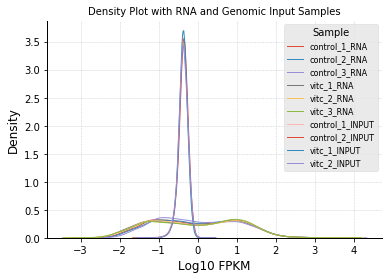

In [137]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", "vitc_1_RNA", "vitc_2_RNA", "vitc_3_RNA", "control_1_INPUT", "control_2_INPUT", "vitc_1_INPUT", "vitc_2_INPUT"]
fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"ARPE_RNA_LOD_Chart.png", dpi=300) # size above specified at 10x6


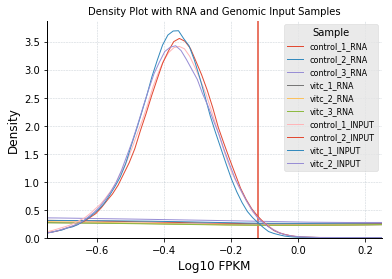

In [138]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", "vitc_1_RNA", "vitc_2_RNA", "vitc_3_RNA", "control_1_INPUT", "control_2_INPUT", "vitc_1_INPUT", "vitc_2_INPUT"]
fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
ax.set_xlim(-0.75,0.25)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')
plt.axvline(x=-0.12)

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"ARPE_RNA_LOD_Chart_Zoomed.png", dpi=300) # size above specified at 10x6

From the graphs above, we can see that they cross at -0.12. This is log base 10, so this converts to 0.75857758 FPKM. I am going to use 0.76 as my limit of detection for simplicity. Moving forward, I am going to keep genes that have one or both sample types averages above 0.76 FPKM. These are the ones that will be used for further analysis.

In [139]:
ARPE_RNA_FPKM_table.head()

,Control_1_FPKM,Control_2_FPKM,Control_3_FPKM,VitC_1_FPKM,VitC_2_FPKM,VitC_3_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC,edgeR,DESeq2,Change
Ensembl_ID,,,,,,,,,,,,,
ENSG00000000003,21.542816,23.742769,24.262241,14.047861,16.561718,13.387857,23.182609,14.665812,0.632621,-0.660586,0.000030,2.790000e-07,Downregulated
ENSG00000000005,0.000000,0.000000,0.110820,0.018848,0.000000,0.000000,0.036940,0.006283,1.000000,0.000000,0.594028,1.000000e+00,Nondifferential
ENSG00000000419,65.020427,65.917011,59.943117,57.473302,53.111115,54.295966,63.626852,54.960128,0.863788,-0.211250,0.582149,3.656105e-02,Nondifferential
ENSG00000000457,4.275969,4.338525,4.018258,4.322483,4.526825,4.018344,4.210917,4.289217,1.018594,0.026580,1.000000,9.196025e-01,Nondifferential
ENSG00000000460,2.422401,2.798705,2.271534,2.677261,3.090301,2.597352,2.497547,2.788304,1.116417,0.158876,0.805784,6.447663e-01,Nondifferential


In [142]:
ARPE_RNA_FPKM_table["Expressed"] = ARPE_RNA_FPKM_table.apply(lambda x: ("Expressed") if (x["VitC_Average_FPKM"] > 0.76 or x["Control_Average_FPKM"]) > 0.76 else "Below_LOD", axis = 1)

In [145]:
ARPE_RNA_FPKM_table.head()

,Control_1_FPKM,Control_2_FPKM,Control_3_FPKM,VitC_1_FPKM,VitC_2_FPKM,VitC_3_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC,edgeR,DESeq2,Change,Expressed
Ensembl_ID,,,,,,,,,,,,,,
ENSG00000000003,21.542816,23.742769,24.262241,14.047861,16.561718,13.387857,23.182609,14.665812,0.632621,-0.660586,0.000030,2.790000e-07,Downregulated,Expressed
ENSG00000000005,0.000000,0.000000,0.110820,0.018848,0.000000,0.000000,0.036940,0.006283,1.000000,0.000000,0.594028,1.000000e+00,Nondifferential,Below_LOD
ENSG00000000419,65.020427,65.917011,59.943117,57.473302,53.111115,54.295966,63.626852,54.960128,0.863788,-0.211250,0.582149,3.656105e-02,Nondifferential,Expressed
ENSG00000000457,4.275969,4.338525,4.018258,4.322483,4.526825,4.018344,4.210917,4.289217,1.018594,0.026580,1.000000,9.196025e-01,Nondifferential,Expressed
ENSG00000000460,2.422401,2.798705,2.271534,2.677261,3.090301,2.597352,2.497547,2.788304,1.116417,0.158876,0.805784,6.447663e-01,Nondifferential,Expressed


In [146]:
ARPE_Expressed_Genes = ARPE_RNA_FPKM_table[ARPE_RNA_FPKM_table["Expressed"] == "Expressed"]

In [148]:
len(ARPE_Expressed_Genes)
# We have 14,599 genes left that are expressed

14599

In [153]:
print("Downregulated Genes:", len(ARPE_Expressed_Genes[ARPE_Expressed_Genes["Change"] == "Downregulated"]))
print("Upregulated Genes:",len(ARPE_Expressed_Genes[ARPE_Expressed_Genes["Change"] == "Upregulated"]))
print("Nondifferential Genes:",len(ARPE_Expressed_Genes[ARPE_Expressed_Genes["Change"] == "Nondifferential"]))

Downregulated Genes: 1434
Upregulated Genes: 3245
Nondifferential Genes: 9920


In [176]:
ARPE_Expressed_Genes.to_csv(Output_Path+"ARPE_Expressed_RNA.csv")
ARPE_Expressed_Genes.to_pickle(Output_Path+"ARPE_Expressed_RNA.pkl")

We can see that we have 3,245 genes that go up and 1,424 genes that go down after treatement with vitamin C. This is much lower than the 9,920 genes that do not change after treatment. This matches the assumption that most genes will not change, and indicates that our treatment was not too extreme.

Now I have a table of the expressed genes, as well as the information about how they react to vitamin C treatment.
The next step is going to be to integrate this with the information that we have generated about the hMeDIP peaks.

In [177]:
ARPE_Expressed_Genes = pd.read_pickle(Output_Path+"ARPE_Expressed_RNA.pkl")
Human_Genomic_Info_File = pd.read_csv(Input_genomic_info_file, sep = ",", index_col = 0 )
summed_counts = pd.read_pickle(Output_Path+"ARPE_Counts_of_peaks_per_region.pkl")

In [170]:
Human_Genomic_Info_File.head()

,Name,Location,Sense,Biotype,transcript_id,Chr,Start,Stop,Length,Exonic Length,Intronic Length,gene_id,gene_version,transcript_version,gene_name,gene_source,gene_biotype,transcript_name,transcript_source,transcript_biotype
Gene_ID,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,TSPAN6,chrX:100627109-100639991,-,protein_coding,ENST00000612152,X,100627109.0,100637104.0,9996.0,3796.0,6200.0,ENSG00000000003,14.0,4.0,TSPAN6,ensembl_havana,protein_coding,TSPAN6-204,ensembl,protein_coding
ENSG00000000005,TNMD,chrX:100584802-100599885,+,protein_coding,ENST00000373031,X,100584802.0,100599885.0,15084.0,1339.0,13745.0,ENSG00000000005,5.0,4.0,TNMD,ensembl_havana,protein_coding,TNMD-201,ensembl_havana,protein_coding
ENSG00000000419,DPM1,chr20:50934867-50958555,-,protein_coding,ENST00000371582,20,50934867.0,50958555.0,23689.0,1161.0,22528.0,ENSG00000000419,12.0,8.0,DPM1,ensembl_havana,protein_coding,DPM1-201,havana,protein_coding
ENSG00000000457,SCYL3,chr1:169849631-169894267,-,protein_coding,ENST00000367771,1,169849631.0,169893952.0,44322.0,6364.0,37958.0,ENSG00000000457,13.0,10.0,SCYL3,ensembl_havana,protein_coding,SCYL3-202,ensembl_havana,protein_coding
ENSG00000000460,C1orf112,chr1:169662007-169854080,+,protein_coding,ENST00000286031,1,169795409.0,169854080.0,58672.0,4355.0,54317.0,ENSG00000000460,16.0,10.0,C1orf112,ensembl_havana,protein_coding,C1orf112-201,ensembl_havana,protein_coding


In [178]:
labels = ARPE_Expressed_Genes[["Change"]]
relevant_genomic_info = Human_Genomic_Info_File[["Name", "Biotype", "Chr", "Length", "Exonic Length"]]

In [179]:
labels.head()

,Change
Ensembl_ID,
ENSG00000000003,Downregulated
ENSG00000000419,Nondifferential
ENSG00000000457,Nondifferential
ENSG00000000460,Nondifferential
ENSG00000000971,Upregulated


In [180]:
relevant_genomic_info.head()

,Name,Biotype,Chr,Length,Exonic Length
Gene_ID,,,,,
ENSG00000000003,TSPAN6,protein_coding,X,9996.0,3796.0
ENSG00000000005,TNMD,protein_coding,X,15084.0,1339.0
ENSG00000000419,DPM1,protein_coding,20,23689.0,1161.0
ENSG00000000457,SCYL3,protein_coding,1,44322.0,6364.0
ENSG00000000460,C1orf112,protein_coding,1,58672.0,4355.0


In [192]:
expressed_genes_info = labels.join(relevant_genomic_info)

In [188]:
expressed_genes_info.groupby(["Biotype"], as_index = False).size()

Biotype
3prime_overlapping_ncRNA                  5
IG_V_gene                                 2
Mt_rRNA                                   2
Mt_tRNA                                  11
TEC                                      28
TR_C_gene                                 1
TR_J_gene                                15
TR_J_pseudogene                           1
antisense_RNA                          1189
bidirectional_promoter_lncRNA             5
lincRNA                                 916
miRNA                                    22
misc_RNA                                 34
processed_pseudogene                    542
processed_transcript                    169
protein_coding                        11228
scRNA                                     1
sense_intronic                            2
sense_overlapping                        49
snRNA                                    48
snoRNA                                    9
transcribed_processed_pseudogene         51
transcribed_unitary_pseu

It is not surprising that the majority of the expressed genes (11,228 of the 14,599) are protein coding genes. It looks like the next most common is antisense (1,189) and lincRNA (916). I may join all of the noncoding types together for further anaylsis.

In [193]:
expressed_genes_info = expressed_genes_info.join(summed_counts)
expressed_genes_info = expressed_genes_info.fillna(0)

In [194]:
expressed_genes_info.head()

,Change,Name,Biotype,Chr,Length,Exonic Length,TSS_Downregulated,Downstream_Promoter_Downregulated,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,TSS_Nondifferential,Downstream_Promoter_Nondifferential,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,TSS_Upregulated,Downstream_Promoter_Upregulated,Gene_Body_Upregulated,Upstream_Promoter_Upregulated
Ensembl_ID,,,,,,,,,,,,,,,,,,
ENSG00000000003,Downregulated,TSPAN6,protein_coding,X,9996.0,3796.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000419,Nondifferential,DPM1,protein_coding,20,23689.0,1161.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ENSG00000000457,Nondifferential,SCYL3,protein_coding,1,44322.0,6364.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
ENSG00000000460,Nondifferential,C1orf112,protein_coding,1,58672.0,4355.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0
ENSG00000000971,Upregulated,CFH,protein_coding,1,95627.0,4127.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [195]:
expressed_genes_info.describe()

,Length,Exonic Length,TSS_Downregulated,Downstream_Promoter_Downregulated,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,TSS_Nondifferential,Downstream_Promoter_Nondifferential,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,TSS_Upregulated,Downstream_Promoter_Upregulated,Gene_Body_Upregulated,Upstream_Promoter_Upregulated
count,1.459900e+04,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000
mean,6.280085e+04,3476.985684,0.002671,0.010823,0.136105,0.012604,0.049387,0.205425,1.644702,0.224741,0.110419,0.342147,1.900267,0.330708
std,1.150453e+05,2869.609131,0.051618,0.104787,0.558936,0.111560,0.234009,0.495142,3.781105,0.530842,0.371804,0.728718,4.845714,0.730941
min,4.800000e+01,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.014000e+03,1460.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.629700e+04,2794.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.702300e+04,4676.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000
max,2.092292e+06,34526.000000,1.000000,2.000000,15.000000,1.000000,4.000000,7.000000,66.000000,8.000000,6.000000,11.000000,106.000000,11.000000


In [196]:
expressed_genes_info.to_csv(Output_Path+"ARPE_Combined_Cleaned_Data.csv")
expressed_genes_info.to_pickle(Output_Path+"ARPE_Combined_Cleaned_Data.pkl")


This is the finally cleaned data. I realize that I did not need to have all of the steps for finding outliers to get the table this way, but it was needed to accurately determine the fold change, which might end up being used in this project and will very likely be used in other projects. Additionally, the corrected FPKM values are needed for heatmaps and were needed to determine the expression threshold. 

Exploration of the data has shown that there are about twice as many upregulated genes as there are downregulated genes in the ARPE dataset, but this is still only about 1/3 of the expressed genes (14,599). Over 2/3 of the expressed genes are protein coding genes (11,228), even though they make up a relatively small portion of the annotated genome. This is consistent with other RNA-seq studies. It looks like the highest average peak counts are genebody upregulated (1.9) followed by genebody nondifferential (1.6). We now have many dimensions and this should be helpful for determining if we can classify genes based on the genomic info and hMeDIP peak information (data about DNA methylation). 